In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tqdm

from flair.data import Sentence
from flair.nn import Classifier
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings
tagger = Classifier.load('sentiment-fast')
glove_embeddings = WordEmbeddings('glove')
document_embeddings = DocumentPoolEmbeddings([WordEmbeddings('glove'),
                                              FlairEmbeddings('fi-forward'),
                                              FlairEmbeddings('fi-backward')])
# twitter_embeddings = WordEmbeddings('twitter')

from sklearn.cluster import KMeans

2023-04-10 19:50:14,667 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/lm-fi-opus-large-forward-v0.1.pt not found in cache, downloading to /var/folders/mc/_plzx65559n4fxtnmj3tqk9w0000gp/T/tmpz1phl445


100%|██████████| 112M/112M [04:52<00:00, 403kB/s]    

2023-04-10 19:55:08,455 copying /var/folders/mc/_plzx65559n4fxtnmj3tqk9w0000gp/T/tmpz1phl445 to cache at /Users/nitanshjain/.flair/embeddings/lm-fi-opus-large-forward-v0.1.pt


2023-04-10 19:55:08,555 removing temp file /var/folders/mc/_plzx65559n4fxtnmj3tqk9w0000gp/T/tmpz1phl445
2023-04-10 19:55:10,454 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/lm-fi-opus-large-backward-v0.1.pt not found in cache, downloading to /var/folders/mc/_plzx65559n4fxtnmj3tqk9w0000gp/T/tmp09rywjqr


100%|██████████| 112M/112M [04:47<00:00, 410kB/s]    

2023-04-10 19:59:59,802 copying /var/folders/mc/_plzx65559n4fxtnmj3tqk9w0000gp/T/tmp09rywjqr to cache at /Users/nitanshjain/.flair/embeddings/lm-fi-opus-large-backward-v0.1.pt
2023-04-10 19:59:59,890 removing temp file /var/folders/mc/_plzx65559n4fxtnmj3tqk9w0000gp/T/tmp09rywjqr


In [25]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_cleaned_translated_v2.csv')
tweets_df.tweet = tweets_df.tweet_translated
tweets_df.drop(['tweet_translated'], axis=1, inplace=True)
print(tweets_df.shape)
tweets_df.head()

(17909, 4)


,tweet_id,tweet,city,year
0,0,bad thing say government medical spare operati...,Mumbai,2022
1,1,netas family admitted government hospital priv...,Mumbai,2022
2,2,govandi one hotspot well respiratory disease f...,Mumbai,2022
3,3,till medical negligence exist government hospi...,Mumbai,2022
4,4,doctor reading also government hospital resident,Mumbai,2022


# Flair Sentiment Analysis

In [26]:
def assign_sentiment_column(df):
    sentiment_flair = list()
    for tweets in df.loc[:,'tweet']:
        sentence = Sentence(tweets)
        tagger.predict(sentence)
        value = sentence.labels[0].to_dict()['value'] 
        if value == 'POSITIVE':
            result = sentence.labels[0].to_dict()['confidence']
        else:
            result = -(sentence.labels[0].to_dict()['confidence'])
        
        if result>0:
            result = 1
        else:
            result = -1
        sentiment_flair.append(result)
    df['sentiment_flair'] = sentiment_flair
    return df

tweets_sentiment_df = assign_sentiment_column(tweets_df)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,sentiment_flair
0,0,bad thing say government medical spare operati...,Mumbai,2022,-1
1,1,netas family admitted government hospital priv...,Mumbai,2022,-1
2,2,govandi one hotspot well respiratory disease f...,Mumbai,2022,-1
3,3,till medical negligence exist government hospi...,Mumbai,2022,-1
4,4,doctor reading also government hospital resident,Mumbai,2022,1


In [27]:
print(tweets_sentiment_df.sentiment_flair.value_counts())
# number of tweets per city grouped by sentiment
print(tweets_sentiment_df.groupby(['city','sentiment_flair']).size())
# number of tweets per year grouped by sentiment
print(tweets_sentiment_df.groupby(['year','sentiment_flair']).size())

sentiment_flair
-1    9374
 1    8535
Name: count, dtype: int64
city       sentiment_flair
Bangalore  -1                 1277
            1                 1022
Chennai    -1                  397
            1                  399
Delhi      -1                 3420
            1                 3376
Hyderabad  -1                 1202
            1                 1201
Kolkata    -1                  565
            1                  454
Mumbai     -1                 2513
            1                 2083
dtype: int64
year  sentiment_flair
2018  -1                 1029
       1                  942
2019  -1                 1338
       1                 1258
2020  -1                 2977
       1                 3025
2021  -1                 2795
       1                 2217
2022  -1                 1235
       1                 1093
dtype: int64


# Sentiment Analysis using Glove Embeddings and Kmeans Clustering


In [28]:
s = torch.zeros(0,100)

for tweets in tweets_df.tweet:
    w = torch.zeros(0,100)
    sentence = Sentence(tweets)
    glove_embeddings.embed(sentence)
    
    for token in sentence:
        w = torch.cat((w,token.embedding.view(-1,100)),0)
    s = torch.cat((s, w.mean(dim = 0).view(-1, 100)),0)

In [29]:
tweets_flair_embeddings = s.numpy()
print(tweets_flair_embeddings.shape)
tweets_flair_embeddings_df = pd.DataFrame(tweets_flair_embeddings)
tweets_flair_embeddings_df['id'] = tweets_df.tweet_id
tweets_flair_embeddings_df.head()

(17909, 100)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,id
0,-0.064289,0.003862,0.143209,-0.074202,-0.226466,0.068645,-0.210656,0.251867,0.089688,0.211687,...,-0.236621,0.090963,-0.071230,-0.271410,0.142085,0.138929,-0.108787,0.263583,0.182786,0
1,0.198516,0.102816,0.090627,0.063674,-0.134824,0.396029,-0.221501,0.136132,0.235028,-0.100459,...,-0.373489,0.213984,-0.078241,-0.329734,0.115201,0.110309,-0.337185,0.281767,-0.049234,1
2,-0.103043,0.063456,0.165817,-0.021750,-0.132317,0.026392,-0.170211,0.060249,0.033756,0.010546,...,-0.250242,-0.030092,0.241225,-0.229829,0.310944,-0.018349,-0.430203,0.470264,0.010353,2
3,-0.045692,0.107114,0.245660,0.083475,-0.198767,0.102131,-0.165644,0.063572,-0.098909,-0.073332,...,-0.222846,-0.068936,0.118087,-0.598880,0.351115,0.177670,-0.192207,0.385357,-0.133041,3
4,-0.006619,0.031942,-0.013060,0.036179,0.084525,0.446597,-0.209093,0.342282,-0.030101,0.140119,...,-0.487452,0.274077,0.295312,-0.650087,0.594145,0.306023,-0.282671,0.371208,-0.234101,4


In [30]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=42).fit(X=tweets_flair_embeddings)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]
plt.scatter(tweets_flair_embeddings[:,0], tweets_flair_embeddings[:,1], c=model.labels_, cmap='viridis', s=5, )

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
labels = model.predict(tweets_flair_embeddings_df.drop(['id'], axis=1))
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [33]:
tweets_sentiment_df['sentiment_flair_embeddings_kmeans_clustering'] = labels
tweets_sentiment_df.replace({'sentiment_flair_embeddings_kmeans_clustering': {0: -1}}, inplace=True)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,sentiment_flair,sentiment_flair_embeddings_kmeans_clustering
0,0,bad thing say government medical spare operati...,Mumbai,2022,-1,-1
1,1,netas family admitted government hospital priv...,Mumbai,2022,-1,-1
2,2,govandi one hotspot well respiratory disease f...,Mumbai,2022,-1,-1
3,3,till medical negligence exist government hospi...,Mumbai,2022,-1,-1
4,4,doctor reading also government hospital resident,Mumbai,2022,1,-1


In [34]:
print(tweets_sentiment_df.sentiment_flair.value_counts())
print(tweets_sentiment_df.sentiment_flair_embeddings_kmeans_clustering.value_counts())

sentiment_flair
-1    9374
 1    8535
Name: count, dtype: int64
sentiment_flair_embeddings_kmeans_clustering
-1    10592
 1     7317
Name: count, dtype: int64


# Sentiment Analysis using Document Embeddings and Kmeans Clustering

In [37]:
matrix = list()

for tweets in tweets_df.tweet:
    sentence = Sentence(tweets)
    document_embeddings.embed(sentence)
    embedding = sentence.get_embedding()
    matrix.append(embedding)
    
matrix

[tensor([-0.0643,  0.0039,  0.1432,  ...,  0.0120,  0.0006,  0.0020]),
 tensor([ 1.9852e-01,  1.0282e-01,  9.0627e-02,  ...,  1.1838e-02,
          2.9758e-06, -5.1321e-03]),
 tensor([-1.0304e-01,  6.3456e-02,  1.6582e-01,  ...,  1.3209e-02,
          2.3788e-05,  1.2090e-02]),
 tensor([-0.0457,  0.1071,  0.2457,  ...,  0.0085,  0.0003,  0.0027]),
 tensor([-0.0066,  0.0319, -0.0131,  ...,  0.0077, -0.0004,  0.0106]),
 tensor([-0.0850, -0.0500,  0.2196,  ...,  0.0074, -0.0005, -0.0020]),
 tensor([-0.0249,  0.2124,  0.0343,  ...,  0.0054,  0.0005,  0.0071]),
 tensor([-0.1421,  0.0120,  0.1680,  ...,  0.0049, -0.0003,  0.0092]),
 tensor([-0.0843,  0.0500,  0.1371,  ...,  0.0094,  0.0008, -0.0003]),
 tensor([ 4.9660e-02,  2.5133e-02,  3.5759e-01,  ...,  9.9369e-03,
         -6.5250e-05,  1.6942e-03]),
 tensor([-0.0502,  0.0901,  0.1220,  ...,  0.0073,  0.0006,  0.0060]),
 tensor([-3.7100e-02,  1.2757e-02,  3.1225e-01,  ...,  1.6776e-02,
          2.6276e-04,  3.0970e-03]),
 tensor([-0.0609

In [42]:
matrix[0].shape

torch.Size([4196])

In [65]:
def convert_to_numpy(tensor):
    tensor = tensor.numpy()  
    return tensor

tweets_flair_document_embeddings = map(convert_to_numpy, matrix)
col_names = [str(i) for i in range(0, 4196)]
tweets_flair_document_embeddings_df = pd.DataFrame(data=tweets_flair_document_embeddings)
tweets_flair_document_embeddings_df['id'] = tweets_df.tweet_id

tweets_flair_document_embeddings = tweets_flair_document_embeddings_df.values
tweets_flair_document_embeddings.shape
tweets_flair_document_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4187,4188,4189,4190,4191,4192,4193,4194,4195,id
0,-0.064289,0.003862,0.143209,-0.074202,-0.226466,0.068645,-0.210656,0.251867,0.089688,0.211687,...,0.005108,-0.000860,0.001368,0.002908,0.003350,0.009082,0.012011,0.000602,0.002003,0
1,0.198516,0.102816,0.090627,0.063674,-0.134824,0.396029,-0.221501,0.136132,0.235028,-0.100459,...,0.004326,-0.000309,-0.000100,0.011346,0.000418,0.008555,0.011838,0.000003,-0.005132,1
2,-0.103043,0.063456,0.165817,-0.021750,-0.132317,0.026392,-0.170211,0.060249,0.033756,0.010546,...,0.002468,-0.000407,0.001179,0.013974,-0.001093,0.009105,0.013209,0.000024,0.012090,2
3,-0.045692,0.107114,0.245660,0.083475,-0.198767,0.102131,-0.165644,0.063572,-0.098909,-0.073332,...,0.004222,-0.001123,0.001855,0.014084,-0.000619,0.012522,0.008475,0.000347,0.002747,3
4,-0.006619,0.031942,-0.013060,0.036179,0.084525,0.446597,-0.209093,0.342282,-0.030101,0.140119,...,0.004626,-0.000142,0.001138,-0.023124,0.000395,0.006212,0.007706,-0.000355,0.010624,4


/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


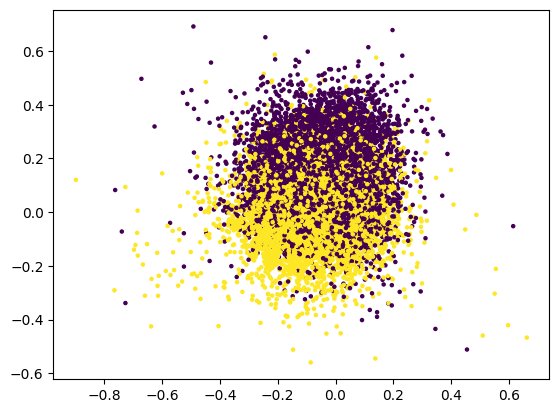

In [63]:
model_document = KMeans(n_clusters=2, max_iter=1000, random_state=42).fit(X=tweets_flair_document_embeddings)
positive_cluster_center_document = model_document.cluster_centers_[0]
negative_cluster_center_document = model_document.cluster_centers_[1]
plt.scatter(tweets_flair_document_embeddings[:,0], tweets_flair_document_embeddings[:,1], c=model.labels_, cmap='viridis', s=5)

In [66]:
labels = model_document.predict(tweets_flair_document_embeddings_df.drop(['id'], axis=1))
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [77]:
tweets_sentiment_df['sentiment_flair_document_embeddings_kmeans_clustering'] = labels
tweets_sentiment_df.replace({'sentiment_flair_document_embeddings_kmeans_clustering': {1: -1}}, inplace=True)
tweets_sentiment_df.replace({'sentiment_flair_document_embeddings_kmeans_clustering': {0: 1}}, inplace=True)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,sentiment_flair,sentiment_flair_embeddings_kmeans_clustering,sentiment_flair_document_embeddings_kmeans_clustering
0,0,bad thing say government medical spare operati...,Mumbai,2022,-1,-1,-1
1,1,netas family admitted government hospital priv...,Mumbai,2022,-1,-1,-1
2,2,govandi one hotspot well respiratory disease f...,Mumbai,2022,-1,-1,-1
3,3,till medical negligence exist government hospi...,Mumbai,2022,-1,-1,-1
4,4,doctor reading also government hospital resident,Mumbai,2022,1,-1,-1


In [79]:
print(tweets_df.sentiment_flair.value_counts())
print(tweets_df.sentiment_flair_embeddings_kmeans_clustering.value_counts())
print(tweets_df.sentiment_flair_document_embeddings_kmeans_clustering.value_counts())

sentiment_flair
-1    9374
 1    8535
Name: count, dtype: int64
sentiment_flair_embeddings_kmeans_clustering
-1    10592
 1     7317
Name: count, dtype: int64
sentiment_flair_document_embeddings_kmeans_clustering
-1    12363
 1     5546
Name: count, dtype: int64


# nltk sentiment

In [81]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
# import textblob

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [82]:
def get_nltk_sentiment(df):
    sia  = SentimentIntensityAnalyzer()
    compound = list()
    for tweets in df.loc[:,'tweet']:
        try:
            compound.append(sia.polarity_scores(tweets)['compound'])
        except:
            compound.append(-100)
    df['nltk_compound'] = compound
    return df

In [85]:
def get_nltk_label_sentiment(df):
    sentiment = list()
    for compound in df.loc[:,'nltk_compound']:
        if compound == -100:
            sentiment.append(np.nan)
        elif compound > 0:
            sentiment.append(1)
        else:
            sentiment.append(-1)
    
    df['nltk_sentiment'] = sentiment
    return df

In [86]:
# tweets_df = get_nltk_sentiment(tweets_df)
tweets_df = get_nltk_label_sentiment(tweets_df)

In [87]:
tweets_df.drop(['nltk_compound'], axis=1, inplace=True)
print(tweets_df.nltk_sentiment.value_counts())

nltk_sentiment
-1    9363
 1    8546
Name: count, dtype: int64


In [78]:
tweets_df.to_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_with_sentiment_v2.csv', index=False)